# **0. Load Preliminary Functions**

## a. Import Libraries and Functions

In [35]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## b. MNIST Data Loader

In [36]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


## c. Training Function

In [37]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


## d. Evaluation Function

In [54]:
def plot_latent_images(model, n, latent_dim=10, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            z = torch.zeros(1, latent_dim, dtype=torch.float32).to(device)
            z[0, 0] = xi
            z[0, 1] = yi
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [55]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        ##################
        ### Problem 1 (a): finish the implementation for encoder and decoder
        ##################
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # remove last ReLU
        encoder_layers = encoder_layers[:-1]
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = []
        prev_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
             decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
             decoder_layers.append(nn.ReLU())
             prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
    def encode(self, x):
        return self.encoder(x)
    def decode(self, z):
        return self.decoder(z)
    def forward(self, input):
        encoded = self.encode(input)
        decoded = self.decode(encoded)
        return {"imgs": decoded}
### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [56]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    return mse(reconstructed, x)

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [256, 64, 10]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.AdamW(ae.parameters(), lr = 1e-3)

input_dim:  784
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
)


## c. Training


In [57]:
##################
### Problem 1 (b): Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)
##################


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0173



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0092



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0087



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0083



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0081



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0079



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0077



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0076



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0074



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0073



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0072



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0072



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0071



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0070



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0070



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0069



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0069



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0068



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0068



## d. Evaluation


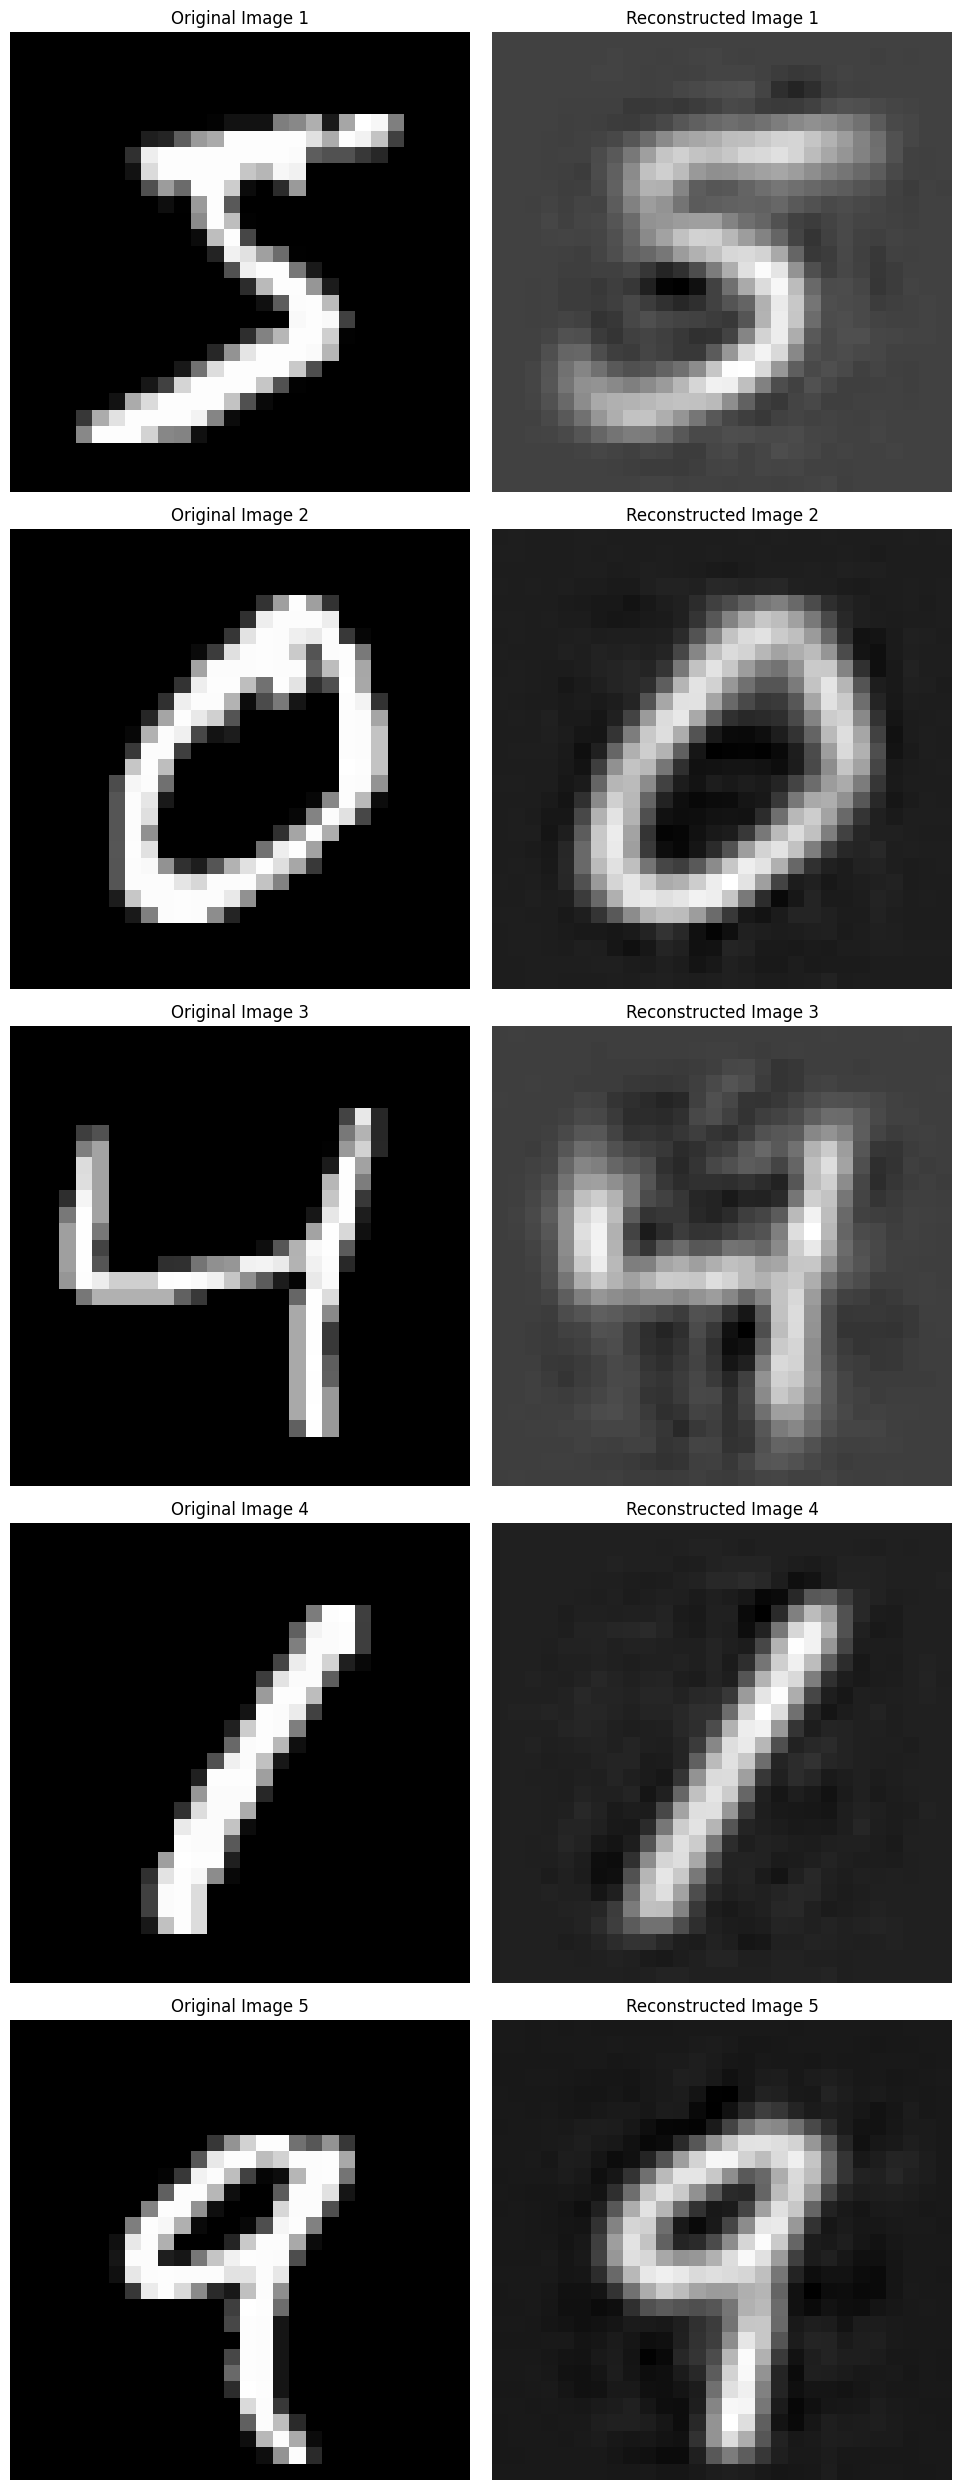

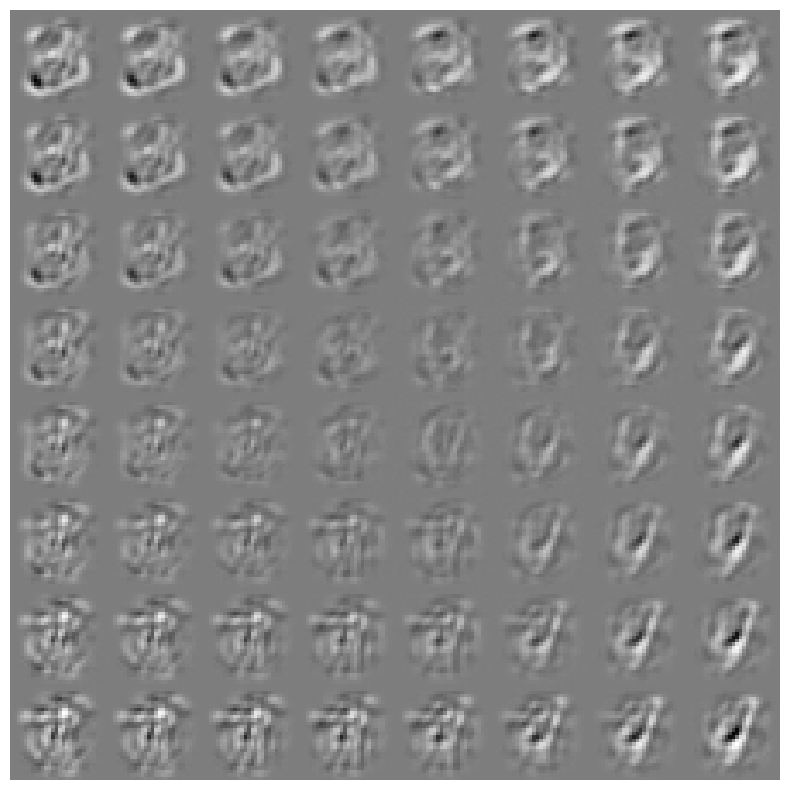

In [58]:
##################
### Problem 1 (b): Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################

# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [59]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2
      if decode_dim == -1:
        decode_dim = input_dim

      self.input_dim = input_dim
      self.decode_dim = decode_dim
      self.use_sigmoid = use_sigmoid
      self.encoder = torch.nn.Sequential()
      self.decoder = torch.nn.Sequential()
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################
      encoder_layers = []
      in_dim = input_dim
      for h_dim in hidden_dims[:-1]:
          encoder_layers.append(nn.Linear(in_dim, h_dim))
          encoder_layers.append(nn.ReLU())
          in_dim = h_dim
      encoder_layers.append(nn.Linear(in_dim, hidden_dims[-1]))
      self.encoder = nn.Sequential(*encoder_layers)

      decoder_layers = []
      in_dim = self.z_size
      for h_dim in reversed(hidden_dims[:-1]):
          decoder_layers.append(nn.Linear(in_dim, h_dim))
          decoder_layers.append(nn.ReLU())
          in_dim = h_dim
      decoder_layers.append(nn.Linear(in_dim, decode_dim))
      if use_sigmoid:
         decoder_layers.append(nn.Sigmoid())
      self.decoder = nn.Sequential(*decoder_layers)

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      return mean + eps * std

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = vae_test(test_tensor)


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [60]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################

    return -0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi).sum(axis=raxis)

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [61]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


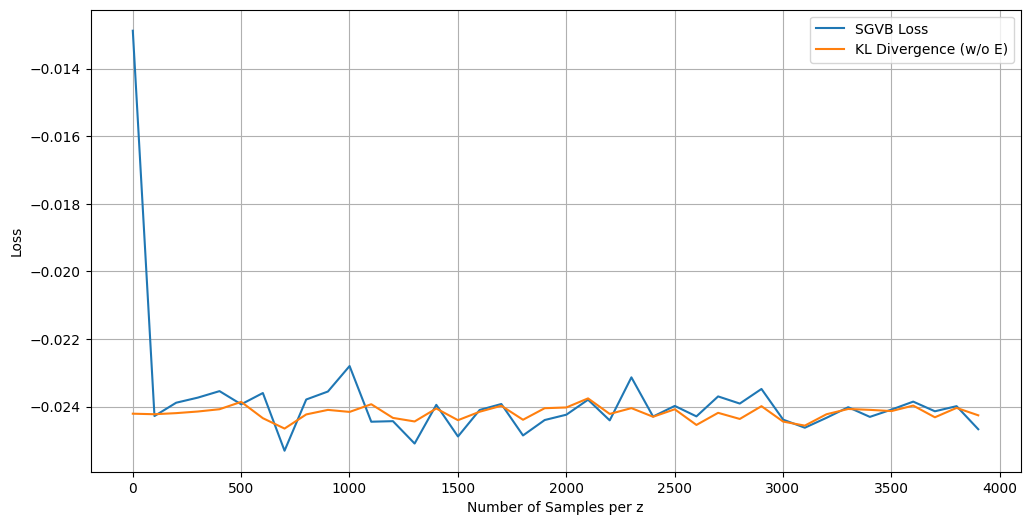

In [62]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [512, 128, 20]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [63]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 20

hidden_dims = [512, 128, 20]
# assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-3

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1e-3), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0387



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0248



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0234



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0224



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0209



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0195



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0188



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0182



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0175



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0151



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0147



## e. Evaluation

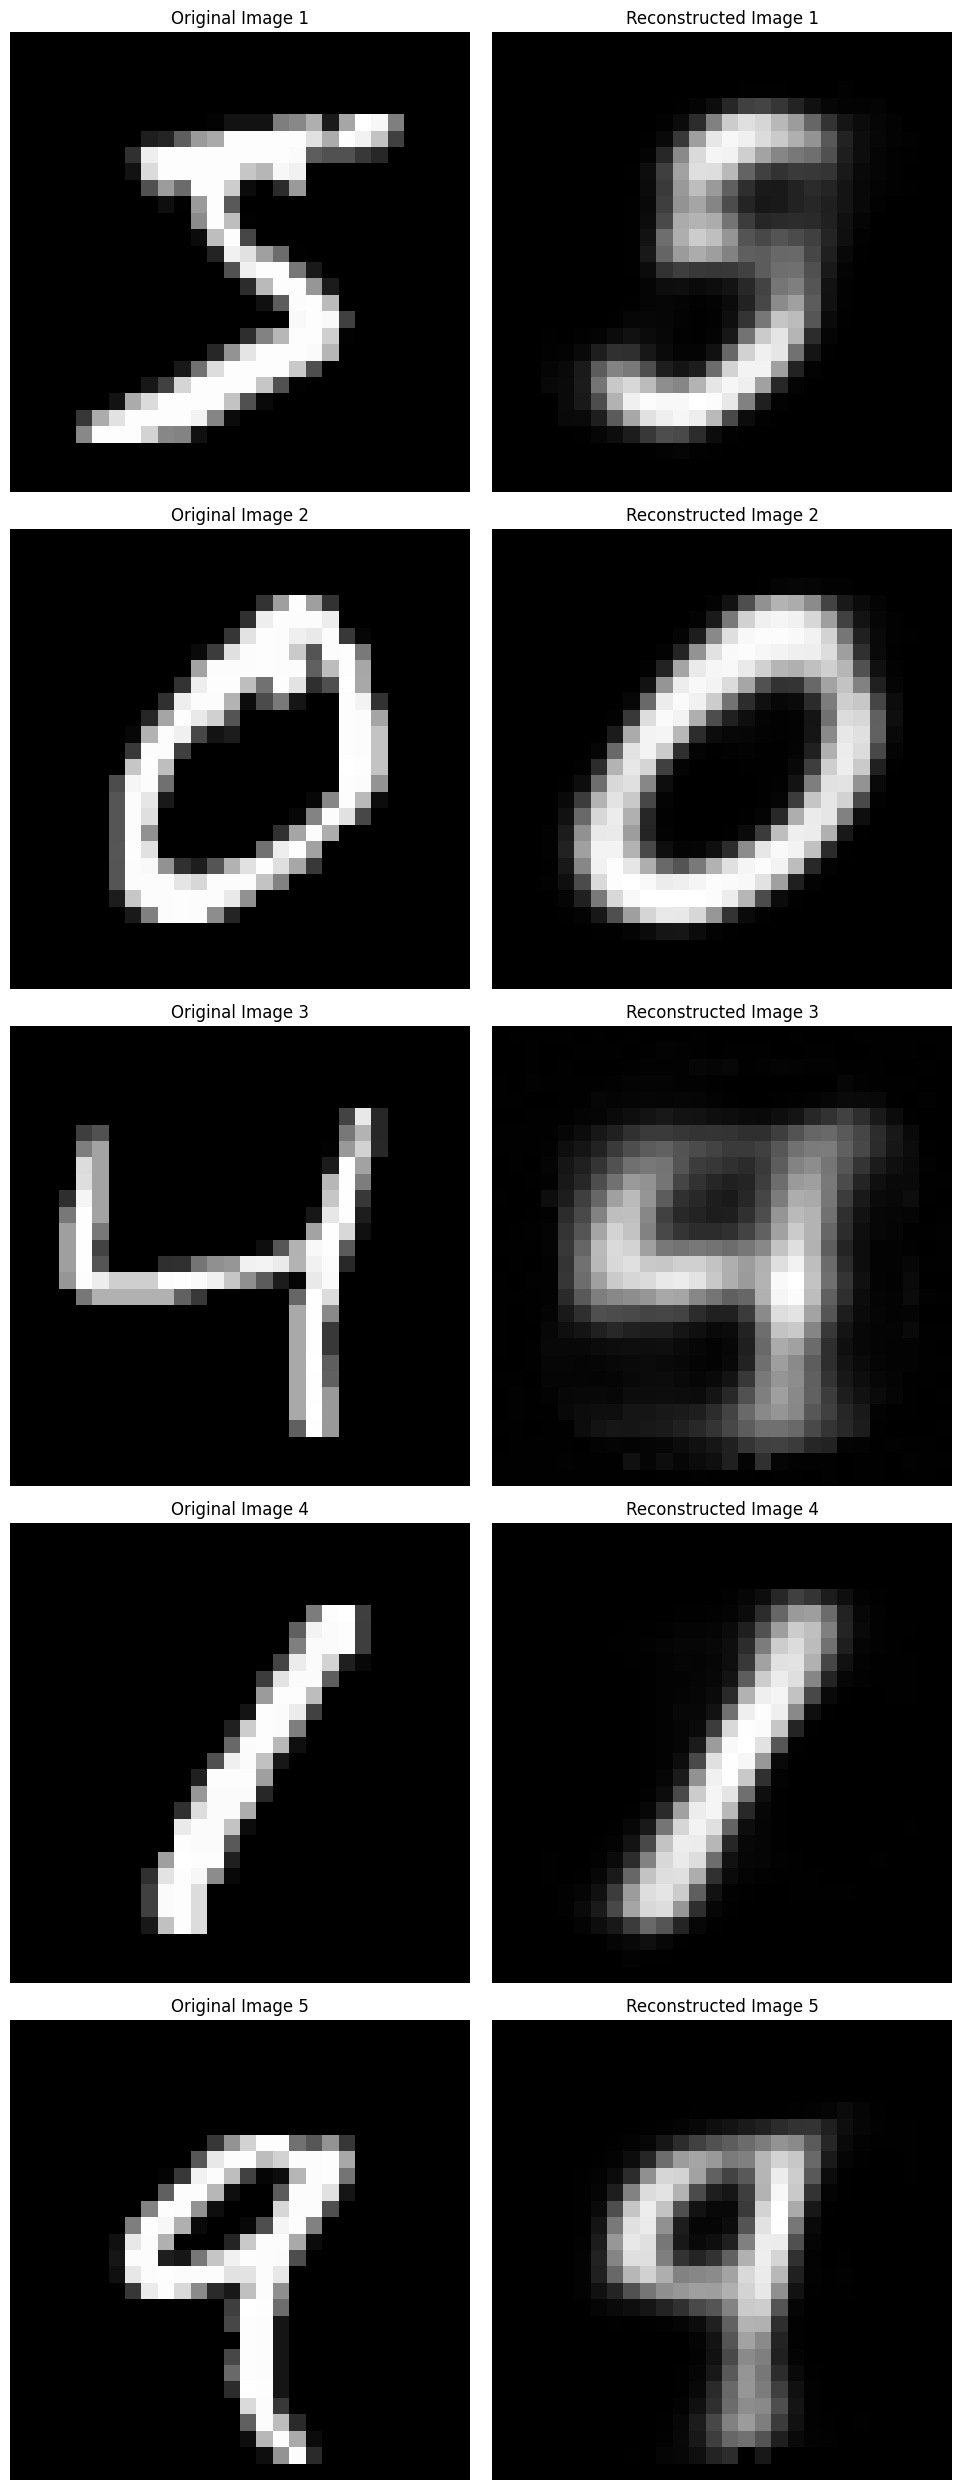

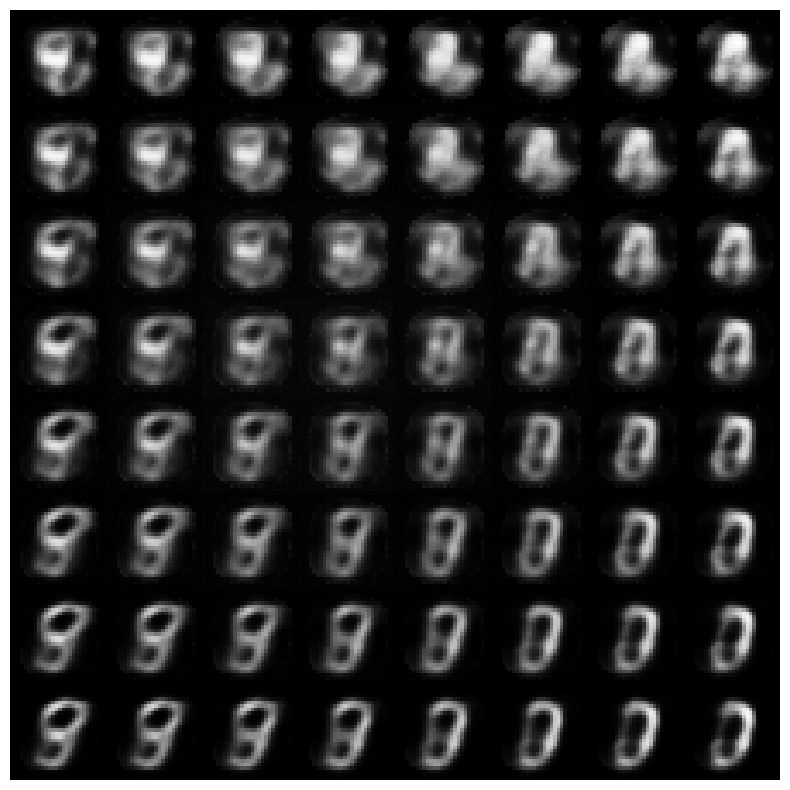

In [64]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [65]:
##################
### Problem 3(c): Train VAE with analytical KL
epochs = 20

hidden_dims = [512, 128, 20]
# assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-3), optimizer_vae_kl_wo_e, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0387



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0249



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0234



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0219



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0200



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0187



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0181



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0176



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0171



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0166



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0151



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0147



## g. Evaluation

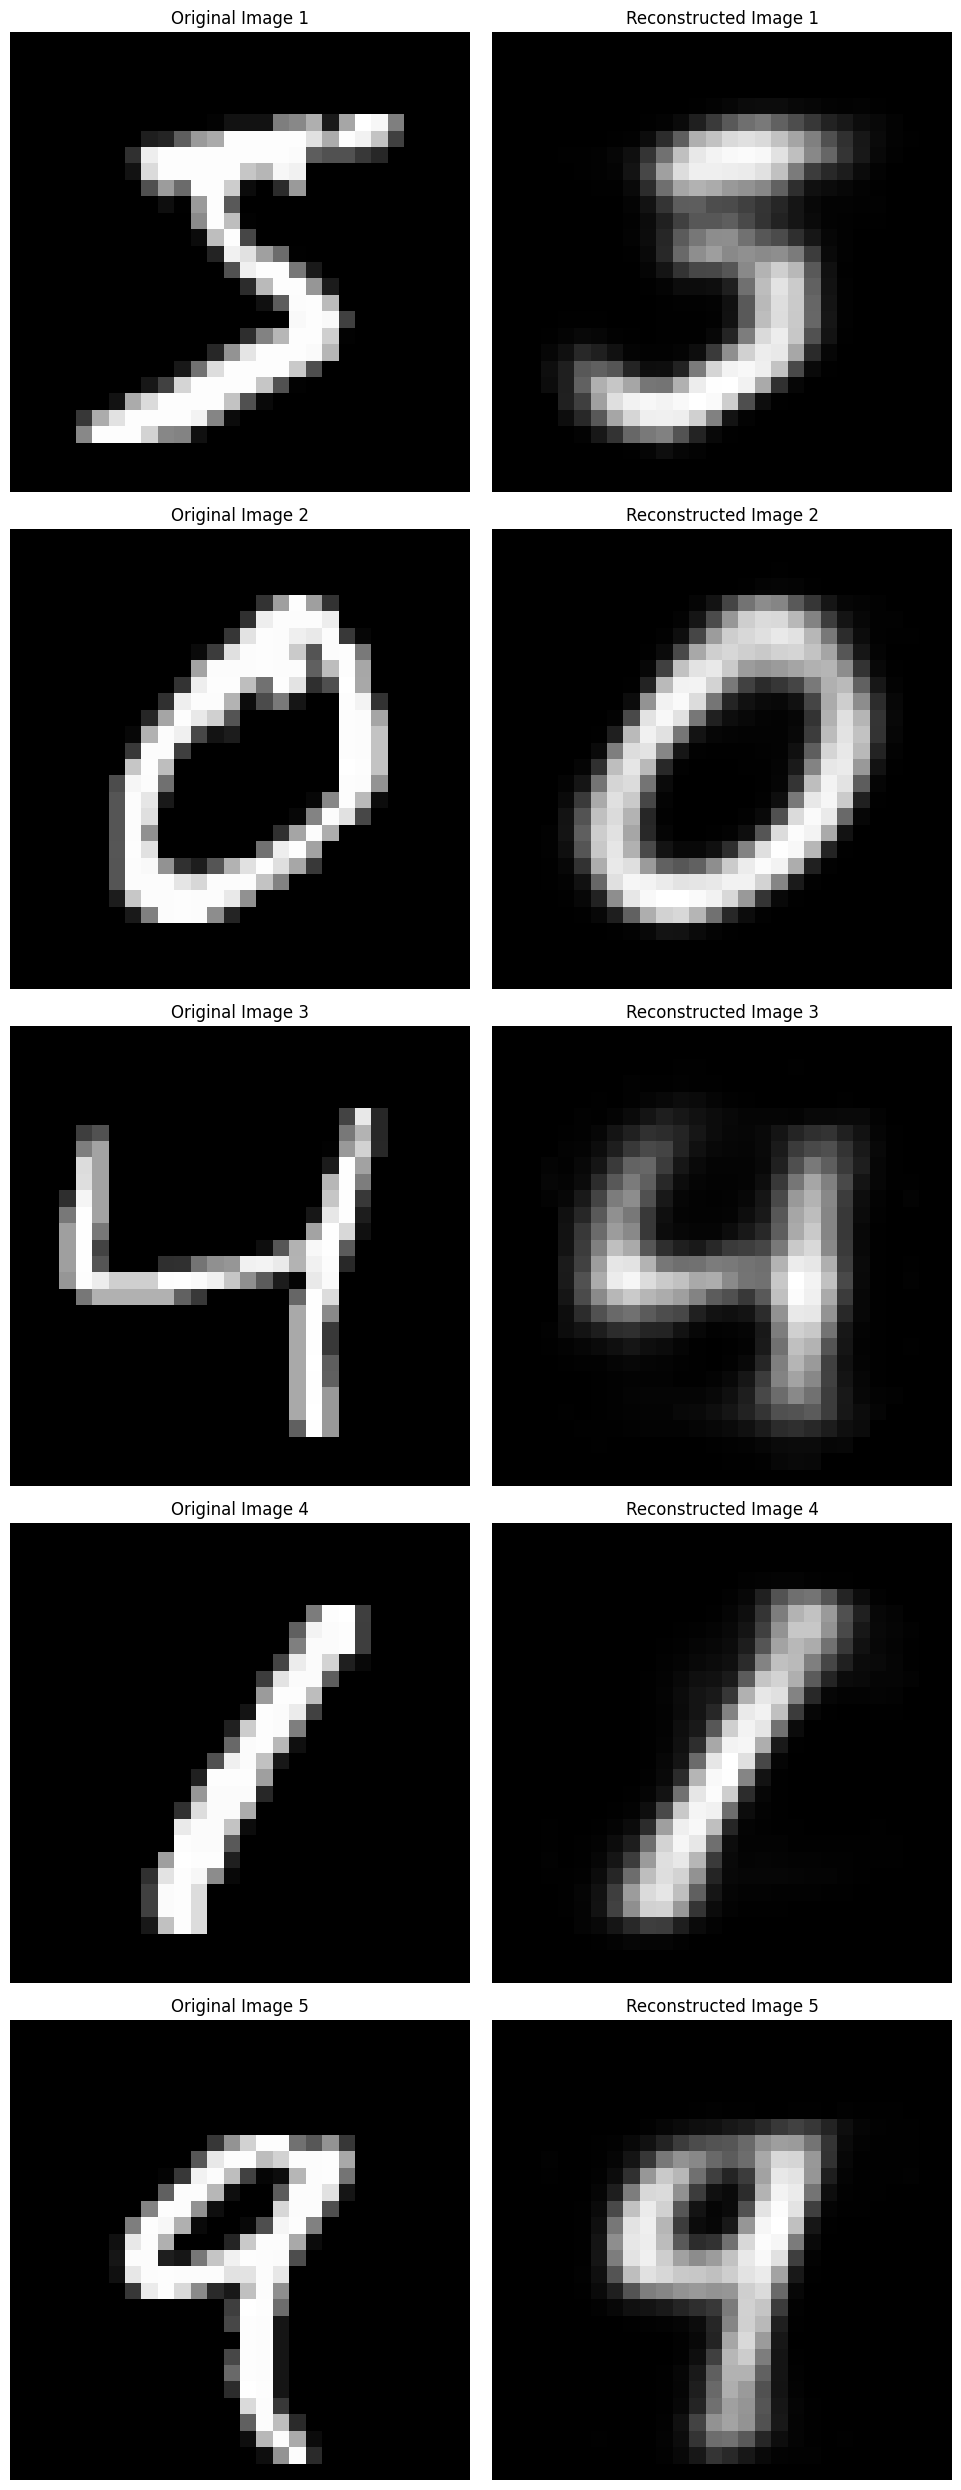

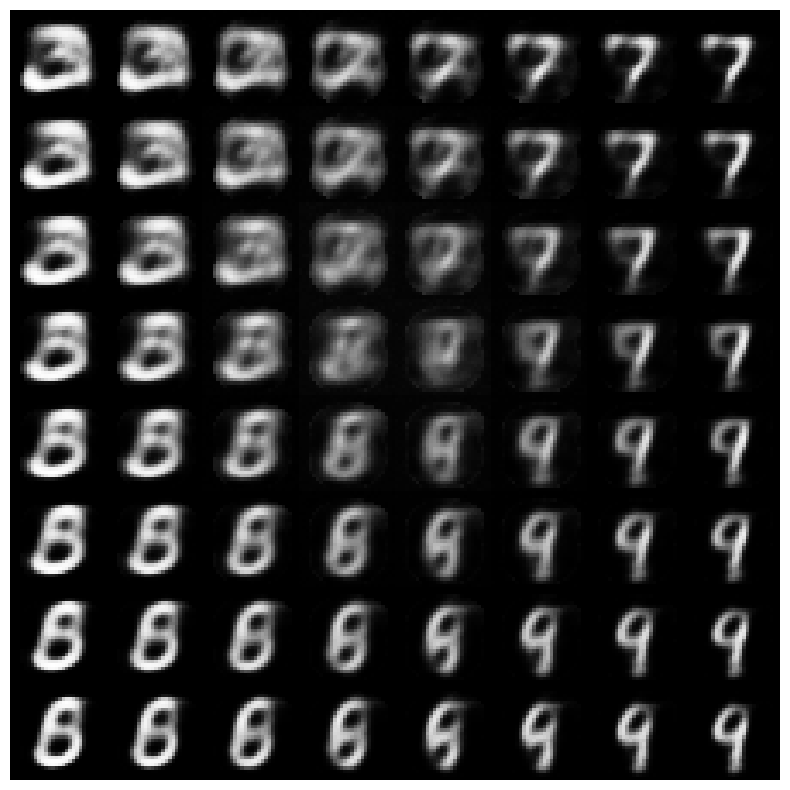

In [66]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################


# **3. Torus**

## a. Data Generation

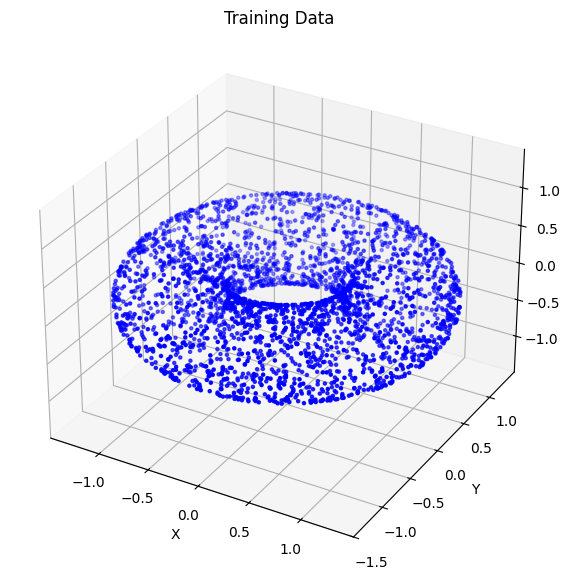

In [67]:
def generate_torus_point_cloud(R, r, num_points=1000, seed=1234):
    """
    Parameters:
    - R: Major radius of the torus (distance from the center of the tube to the center of the torus).
    - r: Minor radius of the torus (radius of the tube).
    - num_points: Number of points to sample in the point cloud.

    Returns:
    - x, y, z: Arrays containing the x, y, and z coordinates of the sampled points.
    """
    np.random.seed(seed)
    u = np.random.uniform(0, 2 * np.pi, num_points)
    np.random.seed(seed+1)
    v = np.random.uniform(0, 2 * np.pi, num_points)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    points = np.vstack((x, y, z)).T

    return points

def plot_torus_point_cloud(x, y, z, ax, color='b', name='Training Data'):
    """
    Plots the 3D point cloud of a torus.
    """
    ax.scatter(x, y, z, c=color, marker='o', s=5)

    # Set equal scaling for all axes
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(name)
    return ax

class TorusPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, R, r, num_points=1000):
        """
        Args:
            R (float): Major radius of the torus.
            r (float): Minor radius of the torus.
            num_points (int): Number of points to generate.
        """
        points = generate_torus_point_cloud(R, r, num_points)
        self.points = torch.tensor(points, dtype=torch.float32)

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], 0 # dummy label

R = 1.0
r = 0.5
num_points = 3000

torus_pc_dataset = TorusPointCloudDataset(R, r, num_points)
torus_pc_dataloader = torch.utils.data.DataLoader(torus_pc_dataset, batch_size=3000, shuffle=True)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(torus_pc_dataset.points[:, 0], torus_pc_dataset.points[:, 1], torus_pc_dataset.points[:, 2], ax)
plt.show()


## b. Network Architecture

In [68]:
class PositionalEncoding3D(torch.nn.Module):
    def __init__(self, num_frequencies=10):
        """
        Initializes the positional encoding for 3D coordinates.

        Args:
            num_frequencies (int): The number of different frequencies to use for encoding.
        """
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = 2 ** torch.arange(num_frequencies, dtype=torch.float32)

    def forward(self, points):
        """
        Applies positional encoding to the 3D points.

        Args:
            points (torch.Tensor): N x 3 tensor of 3D coordinates.

        Returns:
            torch.Tensor: N x (6*num_frequencies) tensor of encoded coordinates.
        """
        encoded_points = []
        for i in range(points.shape[1]):  # For each dimension (x, y, z)
            for freq in self.frequencies:
                encoded_points.append(torch.sin(freq * points[:, i:i+1]))
                encoded_points.append(torch.cos(freq * points[:, i:i+1]))
        return torch.cat(encoded_points, dim=-1)

###############
### Problem 4(c): Create your own VAE
###############

class PointVAE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()

        self.pos_enc = PositionalEncoding3D()
        #############
        ### Problem 4(c): Create your own VAE
        self.vae = VAE(input_dim=self.pos_enc.num_frequencies * 6, hidden_dims=hidden_dims, decode_dim=3, use_sigmoid=False)
        #############

    def forward(self, x):
        emb = self.pos_enc(x)
        return self.vae(emb)


## c. Training

In [71]:
#############
### Problem 4(a): Train VAE on torus data
epochs = 700

hidden_dims = [64, 20] # -> 2/3 dim

point_vae = PointVAE(hidden_dims).to(device)
print(point_vae)

optimizer_point_vae = torch.optim.Adam(point_vae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_point_vae = train(torus_pc_dataloader, point_vae, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=0.0), optimizer_point_vae, epochs)
#############


PointVAE(
  (pos_enc): PositionalEncoding3D()
  (vae): VAE(
    (encoder): Sequential(
      (0): Linear(in_features=60, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=20, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)


Epochs:   0%|          | 0/700 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [1/700], Average Loss: 0.0261



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [2/700], Average Loss: 0.0252



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [3/700], Average Loss: 0.0245



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [4/700], Average Loss: 0.0241



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [5/700], Average Loss: 0.0236



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [6/700], Average Loss: 0.0227



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [7/700], Average Loss: 0.0228



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [8/700], Average Loss: 0.0224



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [9/700], Average Loss: 0.0221



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [10/700], Average Loss: 0.0221



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [11/700], Average Loss: 0.0219



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [12/700], Average Loss: 0.0214



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [13/700], Average Loss: 0.0213



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [14/700], Average Loss: 0.0213



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [15/700], Average Loss: 0.0211



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [16/700], Average Loss: 0.0213



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [17/700], Average Loss: 0.0210



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [18/700], Average Loss: 0.0207



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [19/700], Average Loss: 0.0208



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [20/700], Average Loss: 0.0206



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [21/700], Average Loss: 0.0205



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [22/700], Average Loss: 0.0204



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [23/700], Average Loss: 0.0205



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [24/700], Average Loss: 0.0204



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [25/700], Average Loss: 0.0205



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [26/700], Average Loss: 0.0204



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [27/700], Average Loss: 0.0203



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [28/700], Average Loss: 0.0201



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [29/700], Average Loss: 0.0200



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [30/700], Average Loss: 0.0200



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [31/700], Average Loss: 0.0199



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [32/700], Average Loss: 0.0199



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [33/700], Average Loss: 0.0198



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [34/700], Average Loss: 0.0197



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [35/700], Average Loss: 0.0196



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [36/700], Average Loss: 0.0195



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [37/700], Average Loss: 0.0194



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [38/700], Average Loss: 0.0194



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [39/700], Average Loss: 0.0193



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [40/700], Average Loss: 0.0191



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [41/700], Average Loss: 0.0189



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [42/700], Average Loss: 0.0189



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [43/700], Average Loss: 0.0186



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [44/700], Average Loss: 0.0185



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [45/700], Average Loss: 0.0185



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [46/700], Average Loss: 0.0181



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [47/700], Average Loss: 0.0179



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [48/700], Average Loss: 0.0177



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [49/700], Average Loss: 0.0175



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [50/700], Average Loss: 0.0172



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [51/700], Average Loss: 0.0171



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [52/700], Average Loss: 0.0167



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [53/700], Average Loss: 0.0164



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [54/700], Average Loss: 0.0160



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [55/700], Average Loss: 0.0157



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [56/700], Average Loss: 0.0152



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [57/700], Average Loss: 0.0149



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [58/700], Average Loss: 0.0146



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [59/700], Average Loss: 0.0141



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [60/700], Average Loss: 0.0138



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [61/700], Average Loss: 0.0132



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [62/700], Average Loss: 0.0129



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [63/700], Average Loss: 0.0122



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [64/700], Average Loss: 0.0118



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [65/700], Average Loss: 0.0112



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [66/700], Average Loss: 0.0108



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [67/700], Average Loss: 0.0103



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [68/700], Average Loss: 0.0097



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [69/700], Average Loss: 0.0092



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [70/700], Average Loss: 0.0087



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [71/700], Average Loss: 0.0083



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [72/700], Average Loss: 0.0078



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [73/700], Average Loss: 0.0073



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [74/700], Average Loss: 0.0069



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [75/700], Average Loss: 0.0064



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [76/700], Average Loss: 0.0061



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [77/700], Average Loss: 0.0057



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [78/700], Average Loss: 0.0055



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [79/700], Average Loss: 0.0051



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [80/700], Average Loss: 0.0048



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [81/700], Average Loss: 0.0046



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [82/700], Average Loss: 0.0043



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [83/700], Average Loss: 0.0041



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [84/700], Average Loss: 0.0039



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [85/700], Average Loss: 0.0036



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [86/700], Average Loss: 0.0034



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [87/700], Average Loss: 0.0032



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [88/700], Average Loss: 0.0031



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [89/700], Average Loss: 0.0028



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [90/700], Average Loss: 0.0027



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [91/700], Average Loss: 0.0025



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [92/700], Average Loss: 0.0024



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [93/700], Average Loss: 0.0023



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [94/700], Average Loss: 0.0021



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [95/700], Average Loss: 0.0020



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [96/700], Average Loss: 0.0019



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [97/700], Average Loss: 0.0018



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [98/700], Average Loss: 0.0017



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [99/700], Average Loss: 0.0016



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [100/700], Average Loss: 0.0016



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [101/700], Average Loss: 0.0015



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [102/700], Average Loss: 0.0014



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [103/700], Average Loss: 0.0014



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [104/700], Average Loss: 0.0013



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [105/700], Average Loss: 0.0014



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [106/700], Average Loss: 0.0013



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [107/700], Average Loss: 0.0012



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [108/700], Average Loss: 0.0012



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [109/700], Average Loss: 0.0012



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [110/700], Average Loss: 0.0011



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [111/700], Average Loss: 0.0011



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [112/700], Average Loss: 0.0011



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [113/700], Average Loss: 0.0010



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [114/700], Average Loss: 0.0010



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [115/700], Average Loss: 0.0010



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [116/700], Average Loss: 0.0009



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [117/700], Average Loss: 0.0009



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [118/700], Average Loss: 0.0009



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [119/700], Average Loss: 0.0009



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [120/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [121/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [122/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [123/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [124/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [125/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [126/700], Average Loss: 0.0008



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [127/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [128/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [129/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [130/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [131/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [132/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [133/700], Average Loss: 0.0007



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [134/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [135/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [136/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [137/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [138/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [139/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [140/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [141/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [142/700], Average Loss: 0.0006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [143/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [144/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [145/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [146/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [147/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [148/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [149/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [150/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [151/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [152/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [153/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [154/700], Average Loss: 0.0005



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [155/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [156/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [157/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [158/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [159/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [160/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [161/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [162/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [163/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [164/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [165/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [166/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [167/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [168/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [169/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [170/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [171/700], Average Loss: 0.0004



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [172/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [173/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [174/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [175/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [176/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [177/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [178/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [179/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [180/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [181/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [182/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [183/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [184/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [185/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [186/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [187/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [188/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [189/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [190/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [191/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [192/700], Average Loss: 0.0003



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [193/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [194/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [195/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [196/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [197/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [198/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [199/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [200/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [201/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [202/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [203/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [204/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [205/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [206/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [207/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [208/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [209/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [210/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [211/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [212/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [213/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [214/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [215/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [216/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [217/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [218/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [219/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [220/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [221/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [222/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [223/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [224/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [225/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [226/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [227/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [228/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [229/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [230/700], Average Loss: 0.0002



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [231/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [232/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [233/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [234/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [235/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [236/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [237/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [238/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [239/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [240/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [241/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [242/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [243/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [244/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [245/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [246/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [247/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [248/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [249/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [250/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [251/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [252/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [253/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [254/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [255/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [256/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [257/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [258/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [259/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [260/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [261/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [262/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [263/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [264/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [265/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [266/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [267/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [268/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [269/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [270/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [271/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [272/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [273/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [274/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [275/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [276/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [277/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [278/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [279/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [280/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [281/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [282/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [283/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [284/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [285/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [286/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [287/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [288/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [289/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [290/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [291/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [292/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [293/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [294/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [295/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [296/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [297/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [298/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [299/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [300/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [301/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [302/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [303/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [304/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [305/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [306/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [307/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [308/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [309/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [310/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [311/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [312/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [313/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [314/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [315/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [316/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [317/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [318/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [319/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [320/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [321/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [322/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [323/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [324/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [325/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [326/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [327/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [328/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [329/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [330/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [331/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [332/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [333/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [334/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [335/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [336/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [337/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [338/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [339/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [340/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [341/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [342/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [343/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [344/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [345/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [346/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [347/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [348/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [349/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [350/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [351/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [352/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [353/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [354/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [355/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [356/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [357/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [358/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [359/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [360/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [361/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [362/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [363/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [364/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [365/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [366/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [367/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [368/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [369/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [370/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [371/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [372/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [373/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [374/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [375/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [376/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [377/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [378/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [379/700], Average Loss: 0.0001



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [380/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [381/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [382/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [383/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [384/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [385/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [386/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [387/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [388/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [389/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [390/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [391/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [392/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [393/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [394/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [395/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [396/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [397/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [398/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [399/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [400/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [401/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [402/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [403/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [404/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [405/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [406/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [407/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [408/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [409/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [410/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [411/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [412/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [413/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [414/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [415/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [416/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [417/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [418/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [419/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [420/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [421/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [422/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [423/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [424/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [425/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [426/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [427/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [428/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [429/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [430/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [431/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [432/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [433/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [434/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [435/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [436/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [437/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [438/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [439/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [440/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [441/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [442/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [443/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [444/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [445/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [446/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [447/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [448/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [449/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [450/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [451/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [452/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [453/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [454/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [455/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [456/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [457/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [458/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [459/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [460/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [461/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [462/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [463/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [464/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [465/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [466/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [467/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [468/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [469/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [470/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [471/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [472/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [473/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [474/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [475/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [476/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [477/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [478/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [479/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [480/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [481/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [482/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [483/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [484/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [485/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [486/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [487/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [488/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [489/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [490/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [491/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [492/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [493/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [494/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [495/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [496/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [497/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [498/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [499/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [500/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [501/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [502/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [503/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [504/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [505/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [506/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [507/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [508/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [509/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [510/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [511/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [512/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [513/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [514/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [515/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [516/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [517/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [518/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [519/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [520/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [521/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [522/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [523/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [524/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [525/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [526/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [527/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [528/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [529/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [530/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [531/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [532/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [533/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [534/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [535/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [536/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [537/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [538/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [539/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [540/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [541/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [542/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [543/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [544/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [545/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [546/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [547/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [548/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [549/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [550/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [551/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [552/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [553/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [554/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [555/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [556/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [557/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [558/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [559/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [560/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [561/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [562/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [563/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [564/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [565/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [566/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [567/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [568/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [569/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [570/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [571/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [572/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [573/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [574/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [575/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [576/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [577/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [578/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [579/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [580/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [581/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [582/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [583/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [584/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [585/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [586/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [587/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [588/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [589/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [590/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [591/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [592/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [593/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [594/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [595/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [596/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [597/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [598/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [599/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [600/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [601/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [602/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [603/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [604/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [605/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [606/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [607/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [608/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [609/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [610/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [611/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [612/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [613/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [614/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [615/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [616/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [617/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [618/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [619/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [620/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [621/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [622/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [623/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [624/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [625/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [626/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [627/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [628/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [629/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [630/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [631/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [632/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [633/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [634/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [635/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [636/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [637/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [638/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [639/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [640/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [641/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [642/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [643/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [644/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [645/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [646/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [647/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [648/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [649/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [650/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [651/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [652/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [653/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [654/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [655/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [656/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [657/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [658/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [659/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [660/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [661/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [662/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [663/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [664/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [665/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [666/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [667/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [668/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [669/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [670/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [671/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [672/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [673/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [674/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [675/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [676/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [677/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [678/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [679/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [680/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [681/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [682/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [683/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [684/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [685/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [686/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [687/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [688/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [689/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [690/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [691/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [692/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [693/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [694/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [695/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [696/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [697/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [698/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [699/700], Average Loss: 0.0000



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

----
Epoch [700/700], Average Loss: 0.0000



## d. Evaluation on Reconstruction

<Axes3D: title={'center': 'Decoded Data'}, xlabel='X', ylabel='Y', zlabel='Z'>

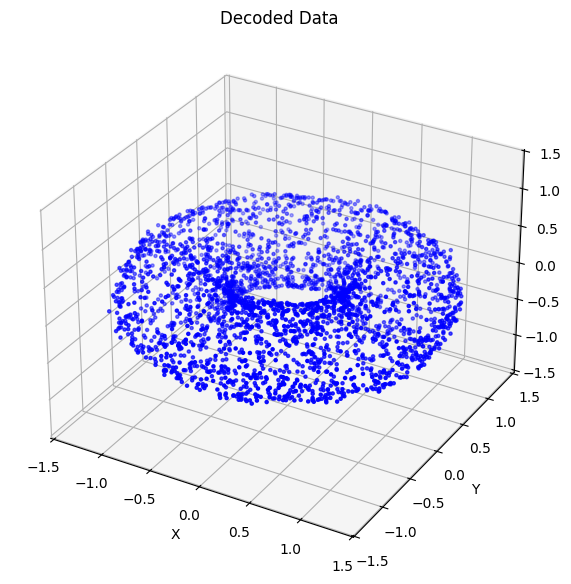

In [72]:
#############
### Problem 4(a): Evaluation on reconstruction
with torch.no_grad():
  output = point_vae(torus_pc_dataset.points.to(device))
  decoded_pc = output['imgs'].cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
#############


## e. Evaluation on Interpolation

20


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5496\3143711611.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))


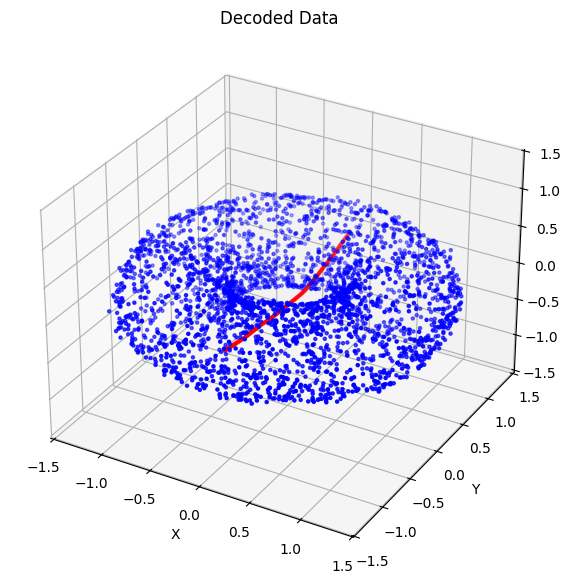

In [73]:
#############
### Problem 4(v): Evaluation on linear interpolation
z0 = point_vae(torch.tensor([[0.0, 1.0, 0.]]).to(device))['z']
z1 = point_vae(torch.tensor([[0.0, -1.0, 0.]]).to(device))['z']

print(hidden_dims[-1])
num_steps = 100

weights = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
latent_vecs = weights * z0 + (1 - weights) * z1

with torch.no_grad():
    outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))

lin_traj = outputs.cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(lin_traj[:, 0], lin_traj[:, 1], lin_traj[:, 2], ax, color='r', name="Decoded Data")
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
plt.show()
#############
